# The Split-Bregman Algorithm: Sparsity Enforcing Inversions

@Author: Francesco Picetti - francesco.picetti@polimi.it

In this notebook we will show the Split-Bregman algorithm,
as described by [Goldstein and Osher, 2009](https://doi.org/10.1137/080725891).

In its generalized unconstrained formulation (the same we handle in this library), this algorithm
takes what we call `ProblemLinearReg` (see `pyProblem.py`):

\begin{equation}
    \arg \min_\mathbf{m} \Vert  \mathbf{A} \mathbf{m} - \mathbf{d}\Vert_2^2 + \sum_i \varepsilon_{L2,i}\Vert \mathbf{R}_{L2,i} \mathbf{m} - \mathbf{p}_i\Vert_2^2 + \sum_i \varepsilon_{L1,i}\Vert \mathbf{R}_{L1,i} \mathbf{m}\Vert_1,
\end{equation}

being $\mathbf{m}$ our model, $\mathbf{d}$ the observed data, $\mathbf{A}$ a linear modeling operator,
$\mathbf{R}_{L2,i}$ the $i$-th linear regularizer to which we associate a prior $\mathbf{p}_i$ along with its weight $\varepsilon_{L2,i}$,
$\mathbf{R}_{L1,i}$ the $i$-th sparsity promoting regularizer and its weight $\varepsilon_{L1,i}$.

#### Import modules

In [1]:
import sys
sys.path.insert(0,"../python")

In [2]:
%load_ext autoreload
%autoreload 2
# Importing necessary modules

import os
import numpy as np
import pyOperator as pyOp
import pyVector as pyVec
import pyNpOperator as NpOp
from pyProblem import ProblemLinearReg, ProblemL2Linear, ProblemL1Lasso
from pyLinearSolver import LSQRsolver, LCGsolver
from pySparseSolver import ISTAsolver, SplitBregmanSolver
from pyStopper import BasicStopper
from sys_util import logger
import genericIO

import pyproximal as pp
from pyProxOperator import ProxOperatorExplicit, ProxOperatorImplicit
from pySolverConstrained import ADMMsolver

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    # 'text.usetex':True
}
matplotlib.rcParams.update(params)

##  Example 1:  1D Ricker Deconvolution

In this example we want to invert a 1D seismic trace for the Earth's reflectivity.
We suppose the wavelet to be known, yielding  to a deterministic deconvolution problem.

In [4]:
# load wavelet
ricker = np.load("../testdata/ricker20.npy")
ricker = genericIO.defaultIO.getVector("../testdata/ricker1.H")
waveletHyper = ricker.getHyper()
nt = waveletHyper.getAxis(1).n
ot = waveletHyper.getAxis(1).o
dt = waveletHyper.getAxis(1).d

# load reflectivity
model = genericIO.defaultIO.getVector('../testdata/ref_randomspikes.H')

# instantating operator
A = NpOp.ConvNDscipy(model, ricker)

# Generating true recorded trace
data = A * model

why exited 


RuntimeError: can not open file ../testdata/ricker1.H

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), ricker.getNdArray())
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(model.getNdArray(), 'k',  label='model')
plt.plot(data.getNdArray(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-1., 1.)
plt.legend()
plt.grid(True)
plt.show()

#### Solve with Conjugate Gradient

Conjugate gradient is a fast and powerful adjoint-state algorithm for solving problems in the form:

\begin{equation}
    \hat{\mathbf{m}} = \arg \min_\mathbf{m} \Vert \mathbf{A}\mathbf{m} - \mathbf{d}\Vert_2^2
\end{equation}

In [ ]:
# instantiate a linear L2 problem
problemCG = ProblemL2Linear(model.clone().zero(), data, A)

# define the solver with 10'000 iterations
CG = LCGsolver(BasicStopper(10000))

# solve the problem
CG.run(problemCG, verbose=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemCG.model.getNdArray(), 'r--', label="CG")
plt.title('Conjugate Gradient, %d iterations' % CG.stopper.niter)
plt.ylim(-1., 1.)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

#### Impose sparsity in the solution: FISTA

Iterative Shrinkage-Thresholding Algorithms solve the so-called LASSO problem:
\begin{equation}
    \hat{\mathbf{m}} = \arg \min_\mathbf{m} \Vert \mathbf{A}\mathbf{m} - \mathbf{d}\Vert_2^2 + \lambda \Vert \mathbf{m}\Vert_1
\end{equation}

If we provide the operator's maximum eigenvalue $\eta$ we can build a fast version
of this algorithm by imposing the step $\alpha < 1/\eta^2$ as proposed in [Beck and Teboulle, 2009](https://doi.org/10.1137/080716542).

In [8]:
# compute maximum eigenvalue
maxeig = A.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))

# define the LASSO problem
problemFISTA = ProblemL1Lasso(model.clone().zero(), data, A, lambda_value=1, op_norm=maxeig**2)

# instantiate the fast solver with 1000 iterations
FISTA = ISTAsolver(BasicStopper(1000), fast=True)

# solve the problem
FISTA.run(problemFISTA, verbose=True)

NameError: name 'A' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemFISTA.model.getNdArray(), 'r--', label="FISTA")
plt.title('Fast ISTA, λ=%.e' % problemFISTA.lambda_value)
plt.ylim(-1, 1)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

Note that FISTA is able to recover the model's kinematics but not the true amplitude.
Indeed, this algorithm is very sensitive to $\lambda$ parameter.
Let's try another solver.

#### Split-Bregman for LASSO problem

In [ ]:
# define the Linear Regularized Problem
problemSB = ProblemLinearReg(model.clone().zero(), data, A,
                             regsL1=pyOp.IdentityOp(model), epsL1=.1)

# instantiate the Split-Bregman solver
SB = SplitBregmanSolver(BasicStopper(1000), niter_inner=5, niter_solver=15,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)

# solve the problem
SB.run(problemSB, verbose=True, inner_verbose=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemFISTA.model.getNdArray(), 'r--', label="SB")
plt.title('Split-Bregman, ε=%.e' % problemSB.epsL1)
plt.ylim(-1, 1)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

The results is much better than FISTA output: the dynamics is almost-perfectly recovered.


##  Example 2:  1D Velocity Deconvolution

Now we create a synthetic velocity profile and suppose to have recorded a smooth version of it.
The deconvolution problem aims at recovering the sharp model, and this is done by using a Total Variation regularizer.

In [3]:
# create the true model
nx = 201
dt = 1./(nx-1)
t = np.linspace(0.0,dt*nx,nx)
x = pyVec.vectorIC(np.zeros((nx,), dtype=np.float32)).zero()
x.getNdArray()[20:30] = 10.
x.getNdArray()[50:75] = -5.
x.getNdArray()[100:150] = 2.5
x.getNdArray()[175:180] = 7.5

# instantiate the blurring operator
G = NpOp.GaussianFilter(x, 2.0)

# simulate data
y = G * x

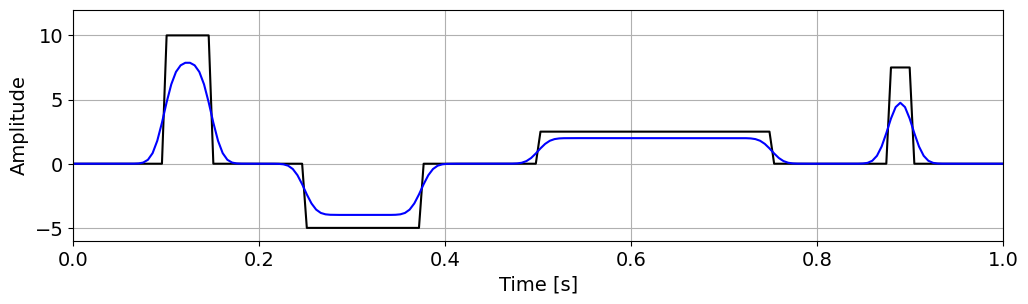

In [4]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(t,x.getNdArray(), 'k',  label='model')
plt.plot(t,y.getNdArray(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-6, 12)
# plt.legend()
plt.grid(True)
# plt.tight_layout(.5)
plt.xlim([0,1])
plt.xlabel("Time [s]",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
# plt.savefig('blocky_model.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

As we can see, the model presents some flat regions. Let's have a look to its first derivative:

In [5]:
TV = NpOp.FirstDerivative(x)
Dx = TV * x

TypeError: tight_layout() takes 0 positional arguments but 1 was given

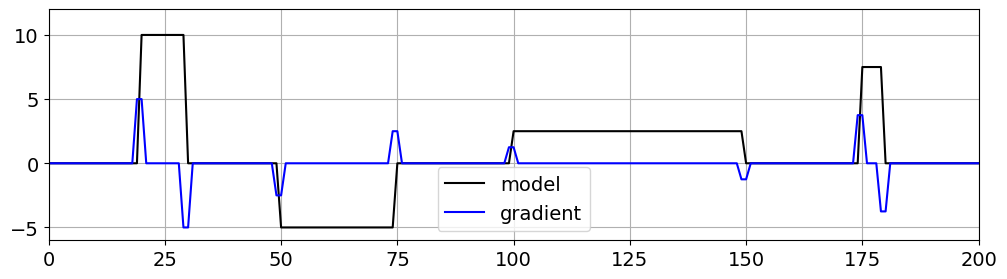

In [6]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'k',  label='model')
plt.plot(Dx.getNdArray(), 'b',  label='gradient')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-6, 12)
plt.legend()
plt.grid(True)
plt.tight_layout(.5)
plt.show()

The model derivative is sparse! We can set up a SplitBregman solver:

In [7]:
problem = ProblemLinearReg(x.clone().zero(), y, G, regsL1=TV, epsL1=.1)

SB = SplitBregmanSolver(BasicStopper(1000), niter_inner=5, niter_solver=10,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)

SB.run(problem, verbose=True, inner_verbose=False)

TypeError: __init__() missing 2 required positional arguments: 'stopper' and 'stepper'

In [27]:
problem = ProblemL2Linear(x.clone().zero(), y, G)
proxOp = ProxOperatorExplicit(pp.TV(x.shape, sigma=0.002, niter=10))
# proxOp = ProxOperator(pp.L1(sigma=1.5))

CG = LCGsolver(BasicStopper(1000), proxOp=proxOp)
CG.setDefaults(save_obj=True, save_model=True)

CG.run(problem, verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /scratch/users/arustam/restart_2025-03-03T16-40-29.222399/
	Modeling Operator:		GausFilt
##########################################################################################

iter = 0000, obj = 5.74471e+02, resnorm = 3.39e+01, gradnorm = 2.58e+01, feval = 2
iter = 0001, obj = 1.33170e+01, resnorm = 5.16e+00, gradnorm = 2.96e+00, feval = 4
iter = 0002, obj = 2.36943e+00, resnorm = 2.18e+00, gradnorm = 8.93e-01, feval = 6
iter = 0003, obj = 9.69057e-01, resnorm = 1.39e+00, gradnorm = 4.90e-01, feval = 8
iter = 0004, obj = 4.94827e-01, resnorm = 9.95e-01, gradnorm = 3.02e-01, feval = 10
iter = 0005, obj = 3.04151e-01, resnorm = 7.80e-01, gradnorm = 2.21e-01, feval = 12
iter = 0006, obj = 1.80206e-01, resnorm = 6.00e-01, gradnorm = 1.54e-01, feval = 14
iter = 0007, obj = 1.14637e-01, resnorm = 4.79e-01, gradnorm = 1.34e-01, feval = 16
iter 

In [33]:
CG = LCGsolver(BasicStopper(1000))
CG.setDefaults(save_obj=True, save_model=True)

rho = 1e-8

proxf = ProxOperatorImplicit(x.clone().zero(), y, G, CG, 1)
proxg = ProxOperatorExplicit(pp.TV(x.shape, sigma=.01, niter=10))
admm = ADMMsolver(proxf, proxg, 10, rho=rho)

admm.run(verbose=True)

			ADMM SOLVER log file

##########################################################################################
			ADMM iteration 0
##########################################################################################

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /scratch/users/arustam/restart_2025-03-03T16-42-14.209251/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 5.74471e+02, resnorm = 3.39e+01, gradnorm = 2.58e+01, feval = 2
iter = 0001, obj = 1.33170e+01, resnorm = 5.16e+00, gradnorm = 2.96e+00, feval = 4
iter = 0002, obj = 2.36944e+00, resnorm = 2.18e+00, gradnorm = 8.93e-01, feval = 6
iter = 0003, obj = 9.69068e-01, resnorm = 1.39e+00, gradnorm = 4.90e-01, feval = 8
iter = 0004, obj = 4.94838e-01, resnorm = 9.95e-01, gradnorm = 3.02e-01, feval = 10
iter = 0005, obj = 3.04162e-0

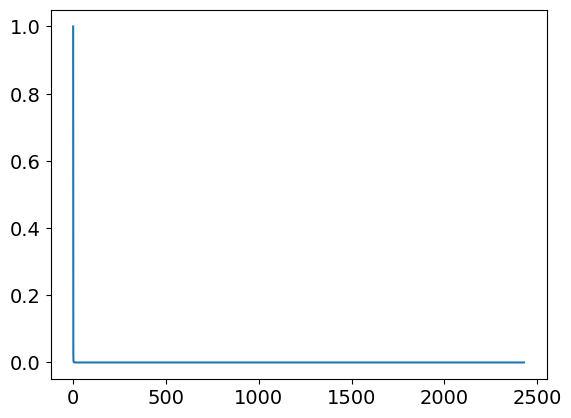

In [34]:
plt.plot(proxf.solver.obj / proxf.solver.obj[0])

Text(0, 0.5, 'Amplitude')

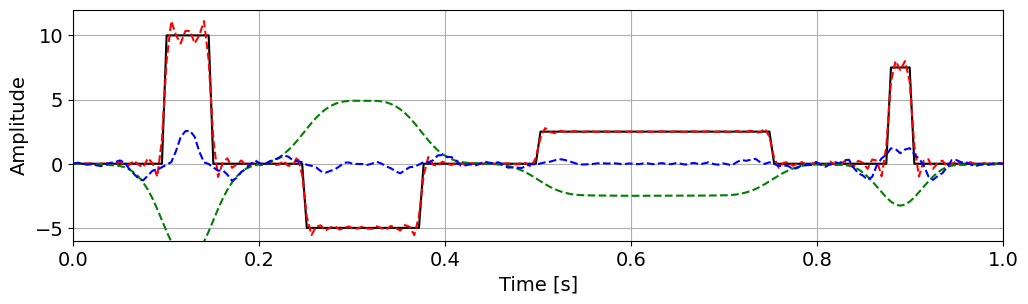

In [35]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(t,x.getNdArray(), 'k', label="true model")
# plt.plot(t,CG.inv_model.getNdArray(), 'cyan', label="true model")
plt.plot(t,admm.x.getNdArray(), 'r--', label="SB")
plt.plot(t,admm.z[:], 'g--', label="SB")
plt.plot(t,admm.u.getNdArray(), 'b--', label="SB")
# plt.title('Split-Bregman, ε=%.e' % problem.epsL1)
plt.ylim(-6, 12)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
# plt.legend()
# plt.tight_layout(.5)
plt.xlim([0,1])
plt.xlabel("Time [s]",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
# plt.savefig('blocky_inversion_sb.pdf', format='pdf', dpi=300, bbox_inches='tight')

##  Example 3: 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

Model:

TypeError: tight_layout() takes 0 positional arguments but 1 was given

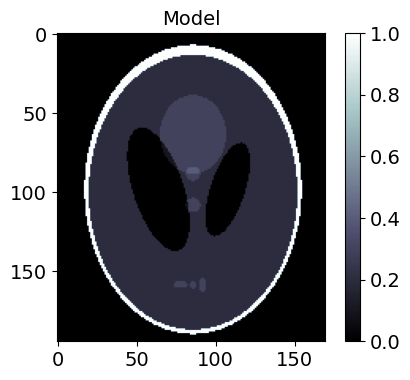

In [91]:
x = pyVec.vectorIC(np.load('../testdata/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32))
x = x.scale(1 / 255.)

plt.figure(figsize=(5, 4))
plt.imshow(x.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.title('Model')
plt.tight_layout(.5)
plt.show()

Data:

TypeError: tight_layout() takes 0 positional arguments but 1 was given

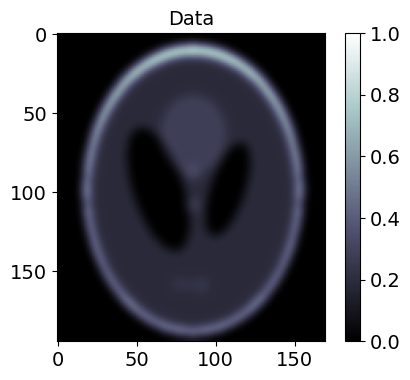

In [92]:
Op = NpOp.GaussianFilter(x, [3, 3])
y = Op * x

plt.figure(figsize=(5, 4))
plt.imshow(y.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.title('Data')
plt.tight_layout(.5)
plt.show()

Problem and solver:

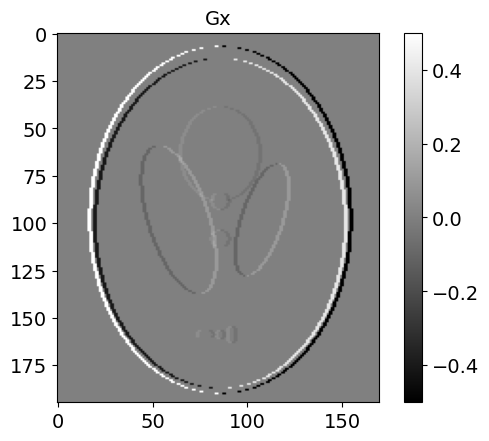

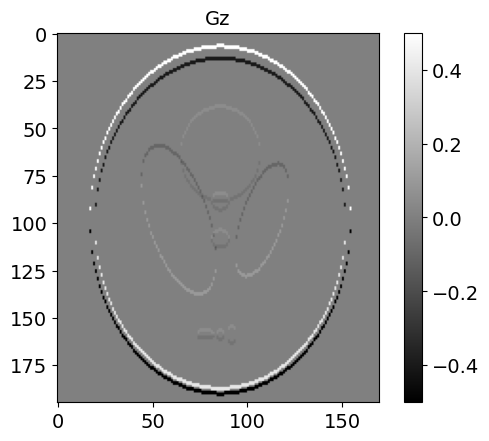

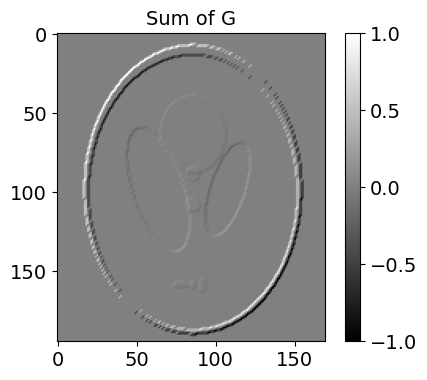

In [93]:
G = NpOp.Gradient(x)

x_grad = G*x
plt.imshow(x_grad.vecs[1].getNdArray(), cmap='gray'), plt.colorbar(), plt.title('Gx'), plt.show()
plt.imshow(x_grad.vecs[0].getNdArray(), cmap='gray'), plt.colorbar(), plt.title('Gz'), plt.show()

# Anisotropic TV
x_grad_aniso = x.clone().zero()
G.merge_directions(False, x_grad, x_grad_aniso, iso=False)
plt.figure(figsize=(5, 4))
plt.imshow(x_grad_aniso.getNdArray(), cmap='gray'), plt.colorbar()
plt.title('Sum of G')
plt.show()

In [61]:
problemSB = ProblemLinearReg(x.clone().zero(), y, Op, regsL1=G, epsL1=1e-3)
SB = SplitBregmanSolver(BasicStopper(niter=200), niter_inner=5, niter_solver=15,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)
SB.run(problemSB, verbose=True, inner_verbose=False)

TypeError: __init__() missing 2 required positional arguments: 'stopper' and 'stepper'

In [100]:

problem = ProblemL2Linear(x.clone().zero(), y, Op)
proxOp = ProxOperator(pp.TV(x.shape, sigma=0.0001, niter=100))
# proxOp = ProxOperator(pp.L1(sigma=1.5))

CG = LCGsolver(BasicStopper(1000), proxOp=proxOp)
CG.setDefaults(save_obj=True, save_model=True)

CG.run(problem, verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /scratch/users/arustam/restart_2025-02-26T16-33-21.725753/
	Modeling Operator:		GausFilt
##########################################################################################

iter = 0000, obj = 6.57986e+02, resnorm = 3.63e+01, gradnorm = 3.28e+01, feval = 2
iter = 0001, obj = 3.05994e+01, resnorm = 7.82e+00, gradnorm = 4.59e+00, feval = 4
iter = 0002, obj = 8.54756e+00, resnorm = 4.13e+00, gradnorm = 1.93e+00, feval = 6
iter = 0003, obj = 3.77593e+00, resnorm = 2.75e+00, gradnorm = 1.09e+00, feval = 8
iter = 0004, obj = 1.99602e+00, resnorm = 2.00e+00, gradnorm = 7.17e-01, feval = 10
iter = 0005, obj = 1.17890e+00, resnorm = 1.54e+00, gradnorm = 4.90e-01, feval = 12
iter = 0006, obj = 7.64838e-01, resnorm = 1.24e+00, gradnorm = 3.72e-01, feval = 14
iter = 0007, obj = 5.42886e-01, resnorm = 1.04e+00, gradnorm = 2.91e-01, feval = 16
iter 

TypeError: tight_layout() takes 0 positional arguments but 1 was given

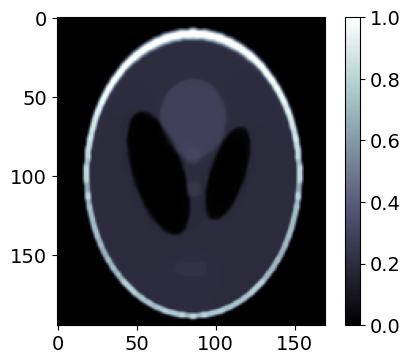

In [101]:
plt.figure(figsize=(5, 4))
plt.imshow(problem.model.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
# plt.title(r'SB TV, $\varepsilon=%.e$, %d iter' % (problemSB.epsL1[0], SB.stopper.niter))
plt.tight_layout(.5)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

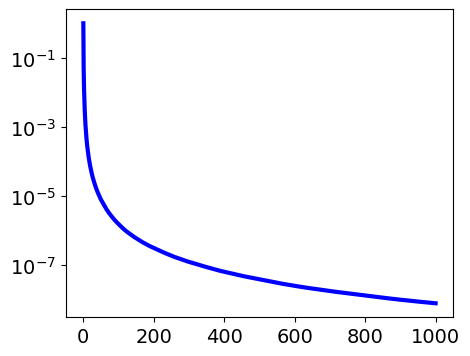

In [102]:
plt.figure(figsize=(5, 4))
plt.semilogy(CG.obj / CG.obj[0], 'b', lw=3, label='Obj')
plt.semilogy(np.asarray(CG.obj_terms)[:, 0] / SB.obj[0], 'r--', label='0.5 $\Vert\cdot\Vert_2^2$')
plt.semilogy(np.asarray(CG.obj_terms)[:, 1] / SB.obj[0], 'y--', label='ε $\Vert\cdot\Vert_1$')
plt.legend()
plt.grid(True)
plt.tight_layout(.5)
plt.title('Convergence curve')
plt.show()